<a href="https://colab.research.google.com/github/kasprowski/smartweld/blob/main/rf_stat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy.io
import os
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


## Loading data
Every file has name: F_<name>_<second>_....

In [ ]:
import numpy as np
def load_file(file):
    mat = scipy.io.loadmat(file)
    vect = []
    for key, value in mat.items() :
        ## use only 11 relevant signals
        if not key.startswith("_") and not key.startswith('orig'):
            v = mat[key]
            vect.append(v)
            #print('>',key, len(v))
    return vect

In [ ]:
dir = 'Converted3a' ## directory name!

def load_samples(dir):
    print('files',len(os.listdir(dir)))
    files_list = os.listdir(dir)
    files_list.sort()
    #files_list.sort()
    samples = []
    labels = []
    names = []
    secs = []
    for file in files_list:
        print('.',end='')
        if "ALE" in file:
            continue
        #print(file)
        v = load_file(f'{dir}/{file}')
        #v = load_stats(f'{dir}/{file}')
        samples.append(v)
        #names.append(int(file[:file.find('_')]))
        names.append(int(file.split("_")[1]))
        secs.append(int(file.split("_")[2]))
        if "Bad" in file:
            labels.append(0)
        else:
            labels.append(1)
        #print(len(samples))
        # for s in samples:
        #     print(len(s))
    samples = np.array(samples)
    labels = np.array(labels)
    names = np.array(names)
    secs = np.array(secs)
    print('done')
    return samples,labels,names,secs
samples, labels, names, secs = load_samples(dir)
print('Samples shape:',samples.shape)


files 1674
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

### Single sample: 11 signals, 25600 values each

In [ ]:
samples[0].shape

(11, 25600, 1)

### Splitting one second samples to shorter (num=10 means 0.1 sec per sample)

In [ ]:
def split_sample(sample,num=10):
    x = np.hsplit(sample,num)
    return np.array(x)
def split_samples(samples,labels,names,num=10):
    ss = []
    ll = []
    nn = []
    for i,s in enumerate(samples):
        ss.append(split_sample(s,num))
        for _ in range(num):
            ll.append(labels[i])
            nn.append(names[i])
    nss = np.concatenate(ss)

    return nss,np.array(ll),np.array(nn)

samples10,labels10,names10 = split_samples(samples,labels,names,10)
print('samples10 shape:',samples10.shape)

Samples10 shape: (8370, 11, 2560, 1)


### For each of 11 signals replace it with statistics: min,max,median,mean,kurtosis,skew - 6 values

In [ ]:
from scipy.stats import kurtosis, skew
def sample2stat(sample):
    vect = []
    for i in range(11):
        s = sample[i]
        v = [np.min(s),np.max(s),np.median(s),np.mean(s),kurtosis(s)[0],skew(s)[0]]
            #vect.append(v)
        vect.extend(v)
        #print(len(vect))
    return vect

def samples2stat(samples):
    v = []
    for s in samples:
        ss = sample2stat(s)
        v.append(ss)
    return np.array(v)

stat_samples = samples2stat(samples)
stat_samples.shape
print('stat_samples shape:',stat_samples.shape)

In [ ]:
stat_samples10 = samples2stat(samples10)
print(stat_samples10.shape)

(8370, 66)


## Classification

Dataset:
- samples, labels, names (837 one second samples, 11x25600 features for each sample)
- samples10, labels10, names10 (8370 0.1 second samples, 11x2560 features for each sample)
- stat_samples, labels, names (837 statistics for one second samples, 11x6 = 66 features for each sample)
- stat_samples10, labels, names (8370 statistics for 0.1 second samples, 11x6 = 66 features for each sample)

## Classify files with the given names-indexes (testSamples) based on all other files (trainSamples)

In [ ]:
def classify_files(file_indexes,samples,labels,names):
    ## we do not randomly split the dataset!
    #(trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples,labels,train_size=prop,stratify=labels)
    trainSamples = []
    trainLabels = []
    testSamples = []
    testLabels = []

    for i,n in enumerate(names):
        if n in file_indexes:
            testSamples.append(samples[i])
            testLabels.append(labels[i])
        else:
            trainSamples.append(samples[i])
            trainLabels.append(labels[i])

    model = RandomForestClassifier(n_estimators=20)
    model.fit(trainSamples, trainLabels)
    results = model.predict(testSamples)
    return testLabels,results

## One-file-leave-out cross validation

Samples from each file are classified based on all other saples from other files

In [ ]:
def cross_validate_files(samples,labels,names,verbose=0):
    correct_labels = []
    found_labels = []
    for i in range(20,71):
        l,r = classify_files([i],samples,labels,names)
        if verbose==1:
            print(confusion_matrix(l, r))
            print(i,'accuracy',accuracy_score(l, r))
            print()
        correct_labels.extend(l)
        found_labels.extend(r)
    print(confusion_matrix(correct_labels, found_labels))
    print(accuracy_score(correct_labels, found_labels))
    return confusion_matrix(correct_labels, found_labels)

## Classification results for four datasets

In [ ]:
# stat_samples
cross_validate_files(stat_samples,labels,names)

[[158  52]
 [ 31 596]]
0.9008363201911589


In [ ]:
# stat_samples10
cross_validate_files(stat_samples10,labels10,names10)

[[1640  460]
 [ 318 5952]]
0.9070489844683393


In [ ]:
# samples (must be reshaped to a vector for Random Forest)
cross_validate_files(samples.reshape(837,-1),labels,names)

[[129  81]
 [ 45 582]]
0.8494623655913979


In [ ]:
# samples10 (must be reshaped to a vector for Random Forest)
cross_validate_files(samples10.reshape(8370,-1),labels10,names10)

[[1411  689]
 [ 300 5970]]
0.8818399044205496


## Results for separate files

In [ ]:
# stat_samples
cross_validate_files(stat_samples,labels,names,verbose=1)

[[22]]
20 accuracy 1.0

[[14]]
21 accuracy 1.0

[[19]]
22 accuracy 1.0

[[19]]
23 accuracy 1.0

[[18]]
24 accuracy 1.0

[[19]]
25 accuracy 1.0

[[18]]
26 accuracy 1.0

[[18]]
27 accuracy 1.0

[[21]]
28 accuracy 1.0

[[18]]
29 accuracy 1.0

[[19]]
30 accuracy 1.0

[[19]]
31 accuracy 1.0

[[16]]
32 accuracy 1.0

[[14]]
33 accuracy 1.0

[[17]]
34 accuracy 1.0

[[17]]
35 accuracy 1.0

[[17]]
36 accuracy 1.0

[[21]]
37 accuracy 1.0

[[16]]
38 accuracy 1.0

[[14]]
39 accuracy 1.0

[[13]]
40 accuracy 1.0

[[11]]
41 accuracy 1.0

[[ 0  1]
 [ 0 10]]
42 accuracy 0.9090909090909091

[[0 2]
 [0 9]]
43 accuracy 0.8181818181818182

[[1 1]
 [0 7]]
44 accuracy 0.8888888888888888

[[0 3]
 [0 6]]
45 accuracy 0.6666666666666666

[[0 2]
 [0 7]]
46 accuracy 0.7777777777777778

[[20]]
47 accuracy 1.0

[[ 0 20]
 [ 0  0]]
48 accuracy 0.0

[[17]]
49 accuracy 1.0

[[16]]
50 accuracy 1.0

[[18]]
51 accuracy 1.0

[[ 0  0]
 [ 4 13]]
52 accuracy 0.7647058823529411

[[ 0  0]
 [ 1 18]]
53 accuracy 0.9473684210526315


# Conclusion:

Najprostsza metoda:

- Podziel plik na próbki długości 1 sekundy (lub 0.1 sekundy)
- Dla każdej próbki policz statystyki dla każdego sygnału (po 6 wartości na sygnał) i złóż je w jeden wektor (11x6 = 66 wartości na każdą próbkę)
- Dla każdego pliku
  - stwórz model RandomForest i wytrenuj go na wszystkich próbkach z pozostałych plików
  - zastosuj ten model do klasyfikacji próbek z tego pliku

Wynik: około 90% poprawnych klasyfikacji

Problemy:

- Bardzo mało jest plików w których są próbki zarówno dobe jak i złe - i w tych plikach najczęściej są błędy klasyfikacji
- Wartości parametrów są mocno uzależnione od momentu spawania - kolejne pliki są do siebie podobne (patrz poniżej)
- Tak więc algorytm wykorzystuje różnice pomiędzy plikami a nie sygnałami

In [ ]:
# stat_samples
cm = cross_validate_files(stat_samples,names,names)

[[ 0 22  0 ...  0  0  0]
 [ 0  0 14 ...  0  0  0]
 [ 0 19  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0 17  0]
 [ 0  0  0 ... 17  0  0]
 [ 0  0  0 ...  0  2  0]]
0.0


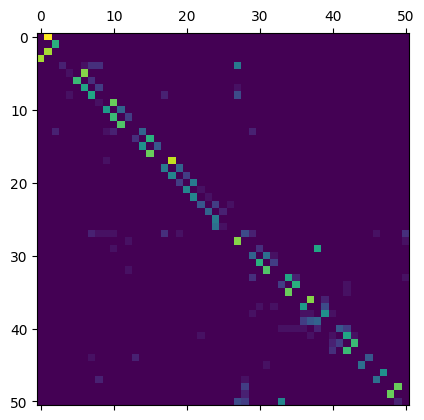

In [ ]:
#widać tu, że pliki OBOK SIEBIE są do siebie podobne. Np próbk z pliku 30 są zwykle klasyfikowane jako 29 lub 31
plt.matshow(cm)